##  <font color='red'> Model 2: Audio recognition using 2D Convolutional Neural Network and MFCC Feature Extraction </font>

### Import libraries

In [1]:
import librosa  #analyzing and extracting features of an audio signal
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
from scipy import signal 
from scipy.io import wavfile 
import tensorflow
import os 
import IPython.display as ipd #allow us to play audio on jupyter notebook directly.It has a very simple interface with some basic buttons.

import math as mt 
import librosa 
from librosa.display import waveplot #plot waveform of amplitude vs time where the first axis is an amplitude and second axis is time.
import pandas as pd

%matplotlib inline 
%pylab inline
pylab.rcParams['figure.figsize'] = (18, 6)

from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, Permute, Dropout, Flatten, Conv2D, BatchNormalization, Input, Reshape, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping


Populating the interactive namespace from numpy and matplotlib


### Import data

In [2]:
train_audio_path = "audio_data/Audio_8hz"

In [3]:
labels=os.listdir(train_audio_path)
labels

['backward',
 'happy',
 'silence',
 'no',
 'nine',
 'stop',
 'zero',
 'up',
 'down',
 'yes',
 'on',
 'forward',
 'off']

In [4]:
labels_to_consider = [
 'backward',
 'down',
 'forward',
 'happy',
 'no',
 'on',
 'off',
 'silence',
 'stop',
 'up',
 'yes']

### Check the baseline using majority classification rule:
#### The majority class in this model is "unknown" with the 19.2% of audio files. So, the baseline of this model is 19.2%

In [5]:
count_unknown = 0
total_count = 0
for label in labels:
    total_count = total_count + len(os.listdir(train_audio_path+ '/' +label))
for label in labels:
    if label == 'zero' or label == 'nine':
        count = len(os.listdir(train_audio_path+ '/' +label))
        count_unknown = count_unknown + count
    else:
        count = len(os.listdir(train_audio_path+ '/' +label))
        print(label+'\t'+str(round(count/total_count*100,1))+'%')
print('unknown' +'\t'+str(round(count_unknown/total_count*100,1))+'%')

backward	4.0%
happy	4.9%
silence	2.7%
no	9.5%
stop	9.3%
up	8.9%
down	9.4%
yes	9.7%
on	9.2%
forward	4.1%
off	9.0%
unknown	19.2%


### Feature extraction of sample audio file:

The first step in any automatic speech recognition system is to extract features i.e. identify the components of the audio signal that are good for identifying the linguistic content and discarding all the other stuff which carries information like background noise, emotion etc.

The main point to understand about speech is that the sounds generated by a human are filtered by the shape of the vocal tract including tongue, teeth etc. This shape determines what sound comes out. If we can determine the shape accurately, this should give us an accurate representation of the phoneme being produced. The shape of the vocal tract manifests itself in the envelope of the short time power spectrum, and the job of MFCCs is to accurately represent this envelope. 

MFCC — Mel-Frequency Cepstral Coefficients:
This feature is one of the most important method to extract a feature of an audio signal and is used majorly whenever working on audio signals. The mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features (usually about 10–20) which concisely describe the overall shape of a spectral envelope.

The following block diagram is a step-wise summary of how we arrived at MFCCs: Here, Filter Bank refers to the mel filters (coverting to mel scale) and Cepstral Coefficients are nothing but MFCCs.

<img src='MFCC.png' style='width:800px;height:400px'>

In [6]:
file_path = "audio_data/Audio_8hz/down/0a2b400e_nohash_3.wav"
max_pad_len=16
audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast', sr = 8000)
mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
pad_width = max_pad_len - mfccs.shape[1]
mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
print(mfccs.shape)

(40, 16)


By printing the shape of mfccs we get to know how many mfccs are calculated on how many frames. The first value represents the number of mfccs calculated and another value represents a number of frames available.

### Define a function for feature extraction of all audio files

In [7]:

max_pad_len = 16
def extract_features(file_name):
    try:
        audio, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, res_type='kaiser_fast', sr = 8000)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')

    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 

    return mfccs


### Save the extracted features in a pandas data frame

In [8]:
features = []
all_label = []
for label in labels:
    count = 0
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        data = extract_features(train_audio_path + '/'+ label + '/' + wav)
        if label in labels_to_consider:
            features.append([data, label])
            all_label.append(label)
        else:
            features.append([data, 'unknown'])
            all_label.append('unknown')

# Convert into a Panda dataframe 
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])

#### Convert the output labels to integer encoded:

In [9]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)

### Final list of classes

In [10]:
classes

['backward',
 'down',
 'forward',
 'happy',
 'no',
 'off',
 'on',
 'silence',
 'stop',
 'unknown',
 'up',
 'yes']

### Convert features and corresponding classification labels into numpy arrays

In [11]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical


X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))


Using TensorFlow backend.


### Split the training and validation data

In [12]:
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(X, yy, test_size=0.2, random_state = 100)

In [13]:
x_train.shape

(33280, 40, 16)

### Create Model

In [14]:

num_rows = 40
num_columns = 16
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], num_rows, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], num_rows, num_columns, num_channels)

num_labels = yy.shape[1]


model = Sequential()
model.add(Conv2D(filters=32, kernel_size=3,padding='same', input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv2D(filters=64, kernel_size=3,padding='same',  activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv2D(filters=64, kernel_size=3,padding='same',  activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv2D(filters=128, kernel_size=3,padding='same',  activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 40, 16, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 8, 32)         0         
_________________________________________________________________
dropout (Dropout)            (None, 20, 8, 32)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 8, 64)         18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 4, 64)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 4, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 4, 64)         3

### Compile Model

In [22]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

### Set early stopping on minimum validation loss

In [23]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 

### Fit Model

In [24]:
history=model.fit(x_train, y_train ,epochs=100, callbacks=[es], batch_size=32, validation_data=(x_test,y_test))

Train on 33280 samples, validate on 8321 samples
Epoch 1/100
33280/33280 [==============================] - 30s 909us/sample - loss: 2.1909 - accuracy: 0.2538 - val_loss: 1.5319 - val_accuracy: 0.5145
Epoch 2/100
33280/33280 [==============================] - 29s 864us/sample - loss: 1.4701 - accuracy: 0.4862 - val_loss: 0.9224 - val_accuracy: 0.6915
Epoch 3/100
33280/33280 [==============================] - 29s 867us/sample - loss: 1.1053 - accuracy: 0.6218 - val_loss: 0.6856 - val_accuracy: 0.8025
Epoch 4/100
33280/33280 [==============================] - 29s 864us/sample - loss: 0.9258 - accuracy: 0.6907 - val_loss: 0.5177 - val_accuracy: 0.8461
Epoch 5/100
33280/33280 [==============================] - 29s 866us/sample - loss: 0.8279 - accuracy: 0.7264 - val_loss: 0.4539 - val_accuracy: 0.8654
Epoch 6/100
33280/33280 [==============================] - 29s 866us/sample - loss: 0.7680 - accuracy: 0.7458 - val_loss: 0.4169 - val_accuracy: 0.8733
Epoch 7/100
33280/33280 [==============

# Save the model 

In [ ]:
model.save('Conv2D_model.h5')

In [1]:
# Evaluating the model on the training and testing set
print("Maximum training accuracy: ", max(history.history['accuracy']))
print("Maximum validation accuracy: ", max(history.history['val_accuracy']))

Maximum training accuracy:  0.84411055
Maximum validation accuracy: 0.9131114


# 2nd Optimizer: Compile Model Using nadam

In [15]:
model.compile(loss='categorical_crossentropy',optimizer='nadam',metrics=['accuracy'])

In [16]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 

# Fit Model

In [17]:
history=model.fit(x_train, y_train ,epochs=100, callbacks=[es], batch_size=32, validation_data=(x_test,y_test))

Train on 33280 samples, validate on 8321 samples
Epoch 1/100
33280/33280 [==============================] - 32s 966us/sample - loss: 2.1436 - accuracy: 0.2861 - val_loss: 1.3661 - val_accuracy: 0.5577
Epoch 2/100
33280/33280 [==============================] - 32s 957us/sample - loss: 1.3847 - accuracy: 0.5198 - val_loss: 0.8385 - val_accuracy: 0.7429
Epoch 3/100
33280/33280 [==============================] - 32s 968us/sample - loss: 1.0552 - accuracy: 0.6412 - val_loss: 0.5968 - val_accuracy: 0.8256
Epoch 4/100
33280/33280 [==============================] - 31s 924us/sample - loss: 0.8856 - accuracy: 0.7056 - val_loss: 0.5051 - val_accuracy: 0.8442
Epoch 5/100
33280/33280 [==============================] - 31s 930us/sample - loss: 0.7964 - accuracy: 0.7368 - val_loss: 0.4448 - val_accuracy: 0.8614
Epoch 6/100
33280/33280 [==============================] - 31s 933us/sample - loss: 0.7466 - accuracy: 0.7553 - val_loss: 0.4255 - val_accuracy: 0.8688
Epoch 7/100
33280/33280 [==============

# Save the model nadam model

In [18]:
model.save('Conv2D_model_nadam.h5')

#### Maximum validation accuracy with Nadam is 91.3% and maximum training accuracy is 84%

# 3rd Optimizer: Compile Model Using Adadelta

In [19]:
model.compile(loss='categorical_crossentropy',optimizer='Adadelta',metrics=['accuracy'])

In [20]:
history=model.fit(x_train, y_train ,epochs=100, callbacks=[es], batch_size=32, validation_data=(x_test,y_test))

Train on 33280 samples, validate on 8321 samples
Epoch 1/100
33280/33280 [==============================] - 32s 947us/sample - loss: 0.5059 - accuracy: 0.8365 - val_loss: 0.3001 - val_accuracy: 0.9067
Epoch 2/100
33280/33280 [==============================] - 31s 920us/sample - loss: 0.4912 - accuracy: 0.8413 - val_loss: 0.2967 - val_accuracy: 0.9088
Epoch 3/100
33280/33280 [==============================] - 30s 905us/sample - loss: 0.4920 - accuracy: 0.8430 - val_loss: 0.2940 - val_accuracy: 0.9081
Epoch 4/100
33280/33280 [==============================] - 30s 894us/sample - loss: 0.4869 - accuracy: 0.8425 - val_loss: 0.2917 - val_accuracy: 0.9102
Epoch 5/100
33280/33280 [==============================] - 29s 885us/sample - loss: 0.4719 - accuracy: 0.8477 - val_loss: 0.2897 - val_accuracy: 0.9105
Epoch 6/100
33280/33280 [==============================] - 29s 880us/sample - loss: 0.4789 - accuracy: 0.8477 - val_loss: 0.2881 - val_accuracy: 0.9112
Epoch 7/100
33280/33280 [==============

33280/33280 [==============================] - 30s 893us/sample - loss: 0.4416 - accuracy: 0.8599 - val_loss: 0.2646 - val_accuracy: 0.9164
Epoch 55/100
33280/33280 [==============================] - 29s 884us/sample - loss: 0.4366 - accuracy: 0.8611 - val_loss: 0.2644 - val_accuracy: 0.9165
Epoch 56/100
33280/33280 [==============================] - 31s 924us/sample - loss: 0.4253 - accuracy: 0.8618 - val_loss: 0.2642 - val_accuracy: 0.9167
Epoch 57/100
33280/33280 [==============================] - 31s 925us/sample - loss: 0.4267 - accuracy: 0.8628 - val_loss: 0.2640 - val_accuracy: 0.9170
Epoch 58/100
33280/33280 [==============================] - 30s 903us/sample - loss: 0.4295 - accuracy: 0.8619 - val_loss: 0.2638 - val_accuracy: 0.9168
Epoch 59/100
33280/33280 [==============================] - 31s 937us/sample - loss: 0.4295 - accuracy: 0.8631 - val_loss: 0.2637 - val_accuracy: 0.9166
Epoch 60/100
33280/33280 [==============================] - 30s 906us/sample - loss: 0.4372 - a

# Save the model

In [21]:
model.save('Conv2D_model_Adadelta.h5')

### Check the maximum validation and training accuracy

In [22]:
# Evaluating the model on the training and testing set
print("Maximum training accuracy: ", max(history.history['accuracy']))
print("Maximum validation accuracy: ", max(history.history['val_accuracy']))

Maximum training accuracy:  0.86697716
Maximum validation accuracy:  0.91827905


### Plot the results

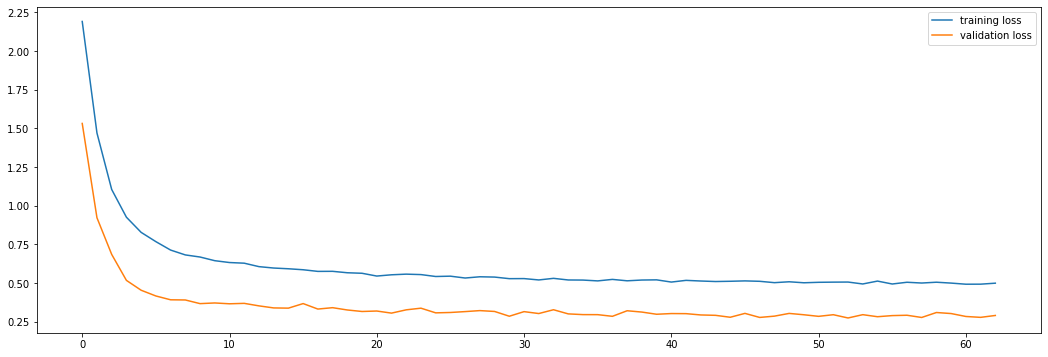

In [27]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='training loss')
pyplot.plot(history.history['val_loss'], label='validation loss')
pyplot.legend()
pyplot.show()

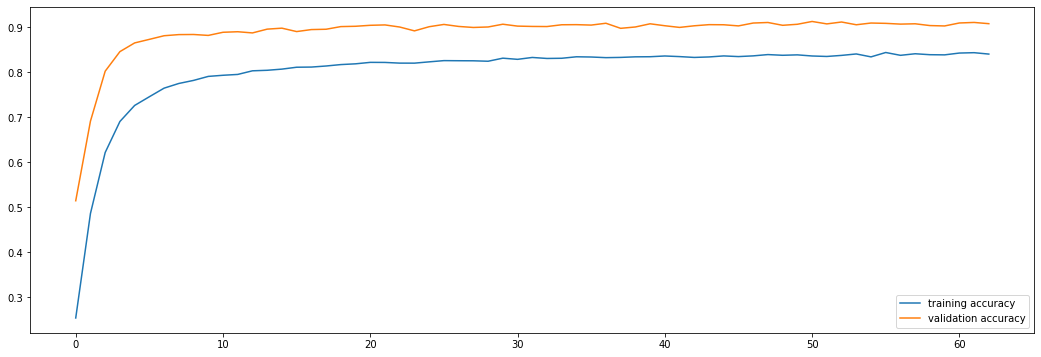

In [28]:
from matplotlib import pyplot
pyplot.plot(history.history['accuracy'], label='training accuracy')
pyplot.plot(history.history['val_accuracy'], label='validation accuracy')
pyplot.legend()
pyplot.show()

### Predictions:


### Make the predictions on validation data

In [89]:
def predict(audio):
    prob=model.predict(audio.reshape(1,40,16,1))
    index=np.argmax(prob[0])
    return classes[index]


import random
for i in range(10):
    index=random.randint(0,len(x_test)-1)
    samples=x_test[index].ravel()
    print("\nAudio:",classes[np.argmax(y_test[index])])
    print("Text:",predict(samples))



Audio: up
Text: off

Audio: down
Text: down

Audio: off
Text: off

Audio: happy
Text: happy

Audio: off
Text: off

Audio: silence
Text: silence

Audio: down
Text: down

Audio: no
Text: no

Audio: down
Text: down

Audio: happy
Text: happy


### Generate a Confusion Matrix

In [75]:
y_pred = model.predict(x_test)

In [76]:
y_pred_again = []
for i in range(len(y_pred)):
    r = np.zeros(12)
    r[np.argmax(y_pred[i])] = 1
    y_pred_again.append(r)

In [77]:
yyyyy = np.array(y_pred_again)

In [78]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), size=11,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)
    plt.savefig('picConfMatrix.png', dpi=400)
    plt.tight_layout()

In [79]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test.argmax(axis=1), yyyyy.argmax(axis=1))

Confusion matrix, without normalization


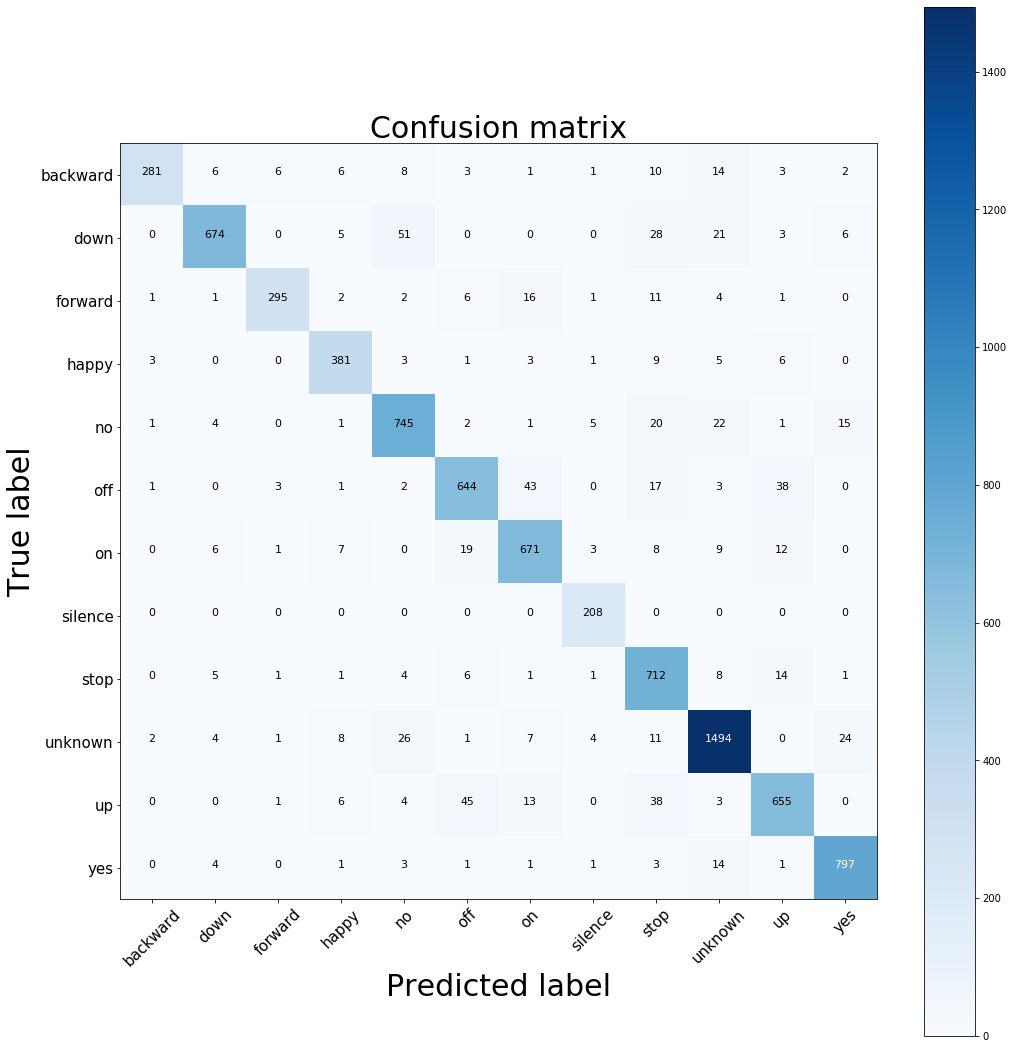

In [80]:
from sklearn.metrics import confusion_matrix

plot_confusion_matrix(cm,classes, normalize=False)